# Titanic: predict surviving of passengers

Main method to predict the survivability of the passengers on board of the Titanic iceberg accident.  This notebook allows for faster prototyping of the ETL process.  Ideally, it would be further extracted into a pure .py file.

### Workflow:
1. Ingest the train and test datasets
2. Pepare the train and test datasets
3. Separate the train dataset into train-train and train-test
4. Train an ML model on the train-train dataset and use the train-test for scoring of the ML model
5. Score the ML model
6. Apply the ML model to the test dataset for predictions
7. Store the predictions to a file

## 0. Setup

In [1]:
# Local modules
import functions as f

# Basic python modules
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import shap

In [2]:
file_train = './../../Data/train.csv'
file_train_clean = ''
file_test = './../../Data/test.csv'
file_pred = './../../Predictions/basicpython.csv'

## 1. Ingestion

We are explicitly moving `PassengerId` to the index of the dataframe

In [3]:
train = pd.read_csv(file_train, sep=',', header='infer', index_col='PassengerId')
test = pd.read_csv(file_test, sep=',', header='infer', index_col='PassengerId')

## 2. Data preparation

In [4]:
train, _ = f.dataprep_titanic(train)
test, _ = f.dataprep_titanic(test)

Text(0.5, 1.0, 'Correlations in the training dataset')

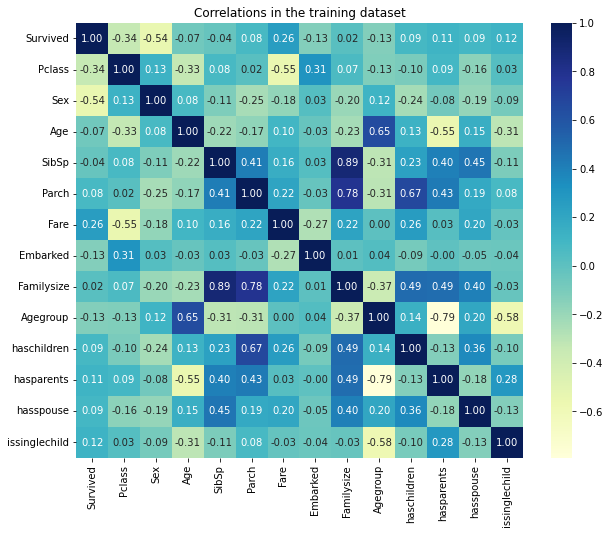

In [5]:
# Quick confirmation of the correlations
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax = sns.heatmap(train.corr(), annot=True, fmt='.2f', cmap="YlGnBu")
ax.set_title('Correlations in the training dataset')

In [6]:
# Selection of the features that need to be passed to the ML model
cols = ['Pclass', 'Sex', 'Age', 
        'SibSp', 'Parch', 'Fare', 'Embarked', 'Familysize', 
        'Agegroup', 'haschildren', 'hasparents', 'hasspouse', 'issinglechild'
       ]

## 3. Subset training data

In [7]:
train_trn, train_tst = train_test_split(train, test_size=0.2, random_state=42, stratify=train['Survived'])

In [8]:
X_trn = train_trn.loc[:, cols].values
X_tst = train_tst.loc[:, cols].values
y_trn = train_trn['Survived'].values
y_tst = train_tst['Survived'].values

## 4. Train ML model

In [9]:
from sklearn.ensemble import RandomForestClassifier

In [10]:
clf = RandomForestClassifier(n_estimators=100,
                             max_depth=5,
                             random_state=42,
                            )

In [11]:
clf.fit(X_trn, y_trn)

RandomForestClassifier(max_depth=5, random_state=42)

## 5. Score the ML model
Different scoring metrics are used to understand what is happening

In [12]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score

In [13]:
pred_trn = clf.predict(X_trn)
pred_tst = clf.predict(X_tst)

Look at the model performance on the train-train subset data

In [14]:
print('Accuracy of {:.2%}'.format(metrics.accuracy_score(y_trn, pred_trn)))
print('Balanced accuracy of {:.2%}'.format(metrics.balanced_accuracy_score(y_trn, pred_trn)))
print('Recall of {:.2%}'.format(metrics.recall_score(y_trn, pred_trn)))
print('Precision of {:.2%}'.format(metrics.precision_score(y_trn, pred_trn)))
print('F1 score of {:.2%}'.format(metrics.f1_score(y_trn, pred_trn)))

print('ROC AUC {:.2%}'.format(metrics.roc_auc_score(y_trn, pred_trn)))

display(metrics.confusion_matrix(y_trn, pred_trn))

Accuracy of 86.24%
Balanced accuracy of 83.23%
Recall of 70.33%
Precision of 91.87%
F1 score of 79.67%
ROC AUC 83.23%


array([[422,  17],
       [ 81, 192]], dtype=int64)

Confirm model performance on the train-test subset data

In [15]:
print('Accuracy of {:.2%}'.format(metrics.accuracy_score(y_tst, pred_tst)))
print('Balanced accuracy of {:.2%}'.format(metrics.balanced_accuracy_score(y_tst, pred_tst)))
print('Recall of {:.2%}'.format(metrics.recall_score(y_tst, pred_tst)))
print('Precision of {:.2%}'.format(metrics.precision_score(y_tst, pred_tst)))
print('F1 score of {:.2%}'.format(metrics.f1_score(y_tst, pred_tst)))

print('ROC AUC {:.2%}'.format(metrics.roc_auc_score(y_tst, pred_tst)))

display(metrics.confusion_matrix(y_tst, pred_tst))

Accuracy of 81.56%
Balanced accuracy of 77.71%
Recall of 60.87%
Precision of 87.50%
F1 score of 71.79%
ROC AUC 77.71%


array([[104,   6],
       [ 27,  42]], dtype=int64)

Look at the SHAP for model explainability.
Steps:
1. Create a SHAP TreeExplainer
2. Give the TreeExplainer the training values (returns a matrix of size (n_classes, n_points, n_features))
3. Summarize the shapvalues per class

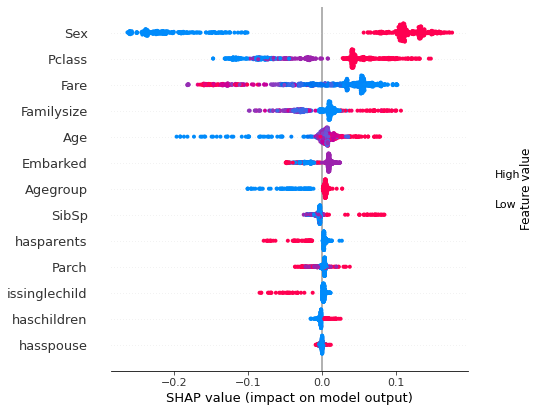

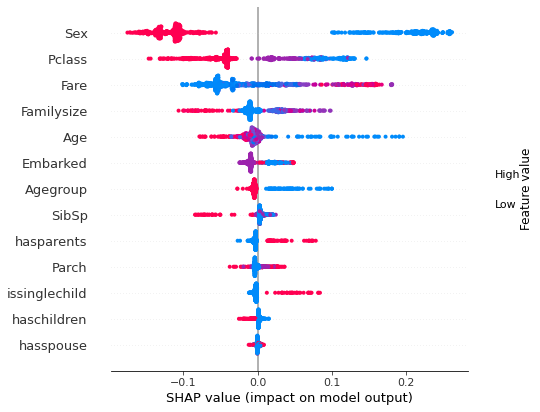

In [16]:
explainer = shap.TreeExplainer(clf)
shapvals = np.array(explainer.shap_values(X_trn))

shap.summary_plot(shapvals[0,:,:], features=X_trn, feature_names=cols)
shap.summary_plot(shapvals[1,:,:], features=X_trn, feature_names=cols)

## 6. Create predictions

In [17]:
test['Survived'] = clf.predict(test.loc[:, cols].values)

In [18]:
predictions = test.loc[:,['Survived']]

In [19]:
predictions

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,0
...,...
1305,0
1306,1
1307,0


## 7. Store the predictions

In [20]:
predictions.to_csv(file_pred, sep=',', header=True)